# rl_trans.ipynb

This model is meant to illustrate how properly timed transitions can make the reward-modulated Hebbian learning rule a powerful way to implement maximization of a value function. The example in this notebook is a version of rl5E_lite modfied to solve the inverted pendulum problem. To this end the x_netB units are replaced with X_netC units.


In [8]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time
from tools.visualization import plotter

/home/z/projects


In [9]:
y = np.arctanh(x)/4.
fig2 = plt.figure()
plt.plot(t,y, t, t, 'k')
plt.show()

NameError: name 'x' is not defined

In [10]:
#===================================================================
#================ CREATE THE NETWORK ===============================
#===================================================================

N = 20 # number of units to represent the angle
#np.random.seed(123456) # always the same random values
np.random.seed()   # different random values ever run


#--------------------------------------------------------------------
# PARAMETER DICTIONARIES
#--------------------------------------------------------------------
net_params = {'min_delay' : 0.005,
              'min_buff_size' : 8 }
# plant parameters
P_params = {'type' : plant_models.pendulum,
            'length' : 0.5,
            'mass' : 1.,
            'init_angle' : 0.,
            'init_ang_vel' : 0.,
            'g' : 9.81,
            'inp_gain' : 2.5,
            'mu' : 1.,
            #'delay' : None, # set after V_params
            'bound_angle' : False,} 
# unit parameters
X_params = {'type' : unit_types.x_netC,
            'multidim' : True,
            #'init_val' : np.concatenate((np.array([0.5]), 0.1*np.ones(N))),
            'init_val' : np.concatenate((np.array([0.5]), 0.1*(np.random.random(N)-.5))),
            'tau' : 0.02,
            'slope' : 10.,
            'lrate' : 100.,
            'trans_t' : .5,
            'tau_fast' : 0.05,
            'tau_mid' : 0.5,
            'tau_slow' : 50.,
            'delay' : .5, # to enlarge activity buffer
            'N' : N,
            'w_sum' : 15.,
            'normalize' : True,
            's_wid' : 10.,
            'beta' : 2.,
            'refr_per' : .5,
            'coordinates' : np.array([0.7, 0.3]) }
            
# units to track synaptic weights or other values
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }

#--------------------------------------------------------------------
# Connection dictionaries
#--------------------------------------------------------------------
# X to plant
X__P_conn = {'inp_ports' : 0,
             'delays': 0.02 }
X__P_syn = {'type': synapse_types.static,
            'init_w' : 1. }
# plant to X
P__X_conn = {'port_map' : [(0,0)],
             'delays' : 0.02 }
P__X_syn = {'type' : synapse_types.static,
            'init_w' : 1. }

#--------------------------------------------------------------------
# CREATING UNITS
#--------------------------------------------------------------------
net = network(net_params)
P = net.create(1, P_params)
X = net.create(1, X_params)

# tracking units
x_track = net.create(N, track_params) # S__X weights
hp_track = net.create(1, track_params)

#--------------------------------------------------------------------
# CONNECTING
#--------------------------------------------------------------------
net.set_plant_outputs(P, X, P__X_conn, P__X_syn)
net.set_plant_inputs(X, P, X__P_conn, X__P_syn)

# SETTING UP TRACKING OF X STATE VARIABLES
def x_track_fun(idx):
    return lambda t: net.units[X[0]].buffer[1+idx,-1]
for idx, uid in enumerate(x_track):
    net.units[uid].set_function(x_track_fun(idx))
net.units[hp_track[0]].set_function(lambda t: net.units[X[0]].hp)

In [11]:
sim_time = 30.
ratio = .25 # shiva
#ratio = .21 # breaker
secs2finish = sim_time * ratio
lt1 = time.localtime()
hrs, hrs_rem = divmod(secs2finish, 3600)
mins, mns_rem = divmod(hrs_rem, 60)
xtra_hrs, new_mins = divmod(lt1.tm_min+mins, 60)
print("Expecting to finish at: %d:%d (%d seconds)" % 
      (lt1.tm_hour+hrs+xtra_hrs, new_mins, secs2finish))
start_time = time.time()

times, data, plant_data  = net.run(sim_time)

print('Execution time is %s seconds' % (time.time() - start_time))
lt2 = time.localtime
print("Finished at " + time.strftime('%H:%M'))
data = np.array(data)

# import cProfile
# import pstats
# cProfile.run('times, data, plant_data = net.run(2.)', 'restats')
# prof = pstats.Stats('restats')
# prof.sort_stats('cumulative').print_stats(30)
# data = np.array(data

Expecting to finish at: 2:30 (7 seconds)
Execution time is 7.0183374881744385 seconds
Finished at 02:30


In [12]:
print("hp=%f"%(net.units[X[0]].hp))
print('lst_hp=%f'%(net.units[X[0]].lst_hp))
print("lst=%f"%(net.units[X[0]].lst))
print("v_init=%f"%(net.units[X[0]].v_init))
print("Dw=")
print(net.units[X[0]].Dw)

hp=-0.074543
lst_hp=29.725000
lst=29.750000
v_init=0.979584
Dw=
[ 0.53569239 -0.0634976  -0.11109254 -0.11158816 -0.11158888 -0.11158888
 -0.11158888 -0.11158888 -0.11158888 -0.11158888 -0.11158888 -0.11158888
 -0.11158888 -0.11158888 -0.11158888 -0.11158884 -0.11153205 -0.10024925
  0.20272191  1.09861176]


Text(0.5, 1.0, 'X--P weights')

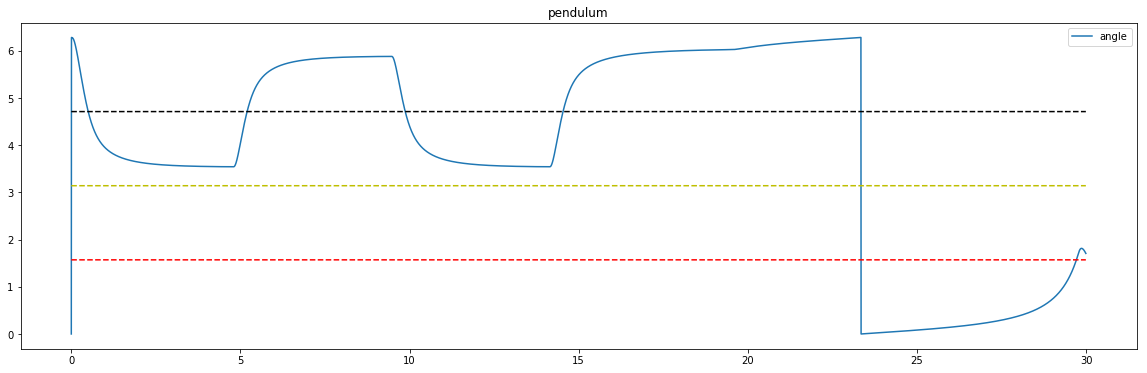

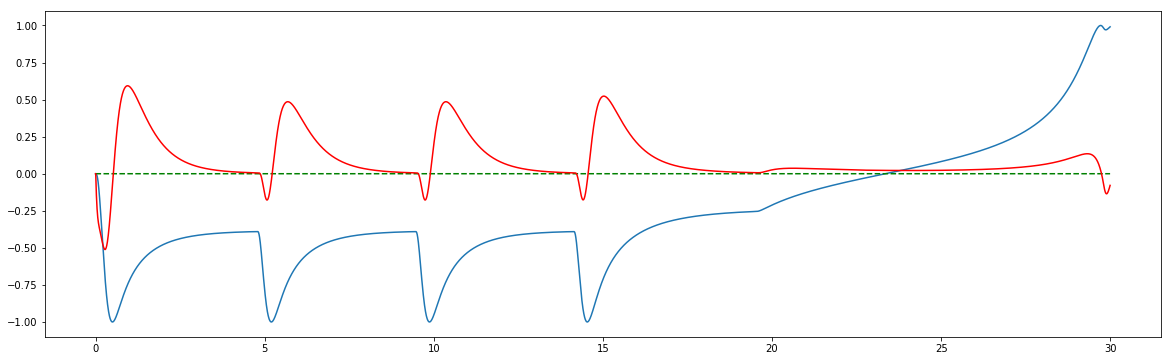

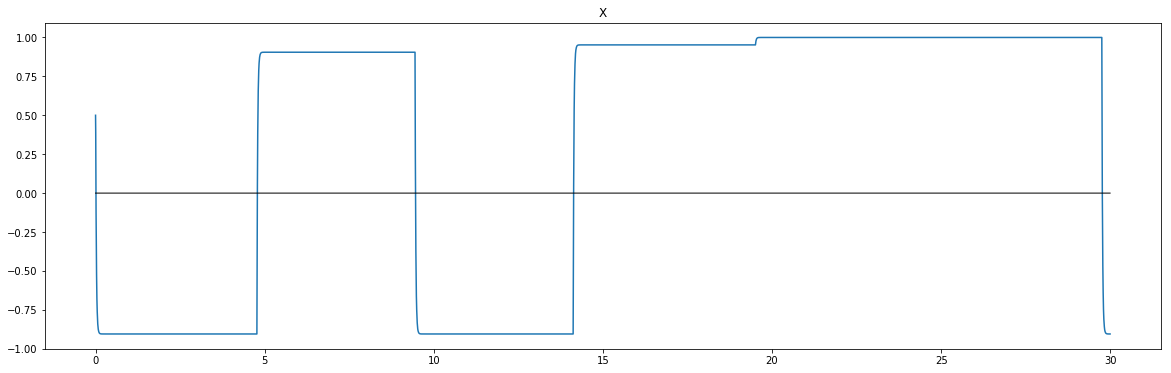

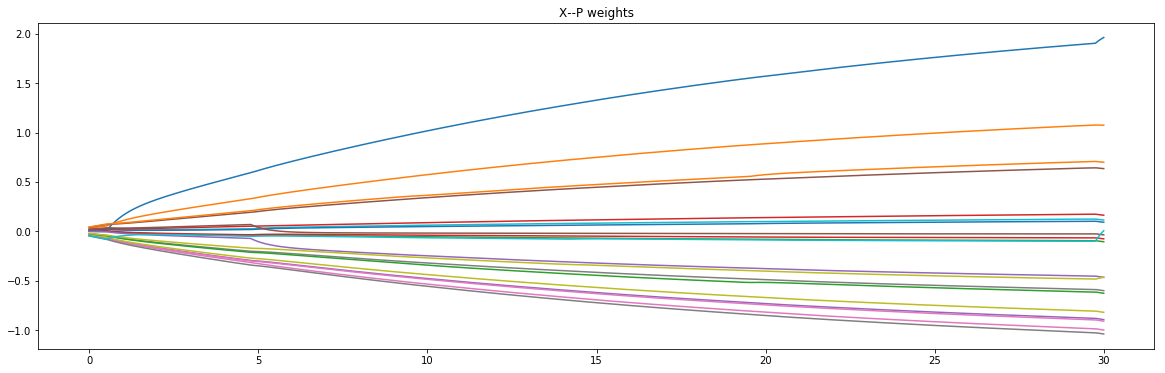

In [13]:
fs = (20,6)

# P
P_fig = plt.figure(figsize=fs)
#P_data = np.mod(plant_data[P], 2.*np.pi)
P_data = plant_data[P]
plt.plot(times, np.mod(P_data[:,0], 2.*np.pi), label='angle')
#plt.plot(times, P_data[:,1], label='ang vel')
plt.plot(times, 3.*np.pi/2.*np.ones_like(times), 'k--')
plt.plot(times, np.pi*np.ones_like(times), 'y--')
plt.plot(times, np.pi/2.*np.ones_like(times), 'r--')
plt.legend()
plt.title('pendulum')
#print("angle: %f, vel: %f" % (P_data[-1,0],P_data[-1,1]))

# height
h_fig = plt.figure(figsize=fs)
plt.plot(times, np.sin(P_data[:,0]))
plt.plot(times, np.zeros_like(times), 'g--')
hp_data = np.array(data[hp_track[0]])
plt.plot(times, hp_data, 'r')

# X
X_fig = plt.figure(figsize=fs)
X_data = np.array(data[X])
plt.plot(times, X_data.transpose())
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
#plt.ylim([-0.05,1.05])
#plt.legend(['X'])
plt.title('X')

# X--P weights
W_fig = plt.figure(figsize=fs)
w_track_data = np.array(data[x_track])
plt.plot(times, w_track_data.transpose())
plt.title('X--P weights')


In [14]:
# Testing amount of change in the weights
print("Maximum minus minimum, X:")
print(max(net.units[X[0]].buffer[1:,-1]) - min(net.units[X[0]].buffer[1:,-1]))

print("\nSum of absolute values S--X weights")
print(np.abs(net.units[X[0]].buffer[1:,-1]).sum())

print("\nSum of S--X weights")
print(net.units[X[0]].buffer[1:,-1].sum())

print("\n v_init=%f"%(net.units[X[0]].v_init))

Maximum minus minimum, X:
3.0025131204327002

Sum of absolute values S--X weights
11.786705279930448

Sum of S--X weights
-2.2895519306950125

 v_init=0.979584


In [15]:
net.units[X[0]].buffer[1:,-1]

array([ 1.96324346,  1.07411289, -0.10526724, -0.07603879, -0.89405318,
        0.63487019, -0.90952141, -0.6007608 , -0.82014236,  0.11408564,
        0.09197775,  0.69943469, -0.62718187,  0.16328683, -0.46551563,
       -0.03575093, -0.9996744 , -1.03926966, -0.46495234,  0.00756523])

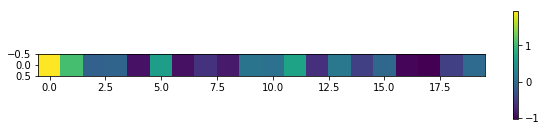

In [16]:
weights = net.units[X[0]].buffer[1:,-1]
d_fig = plt.figure(figsize=(10,2))
d_ax = plt.subplot(1,1,1)
cs = d_ax.imshow(weights.reshape(1,N))
d_fig.colorbar(cs)
plt.show()

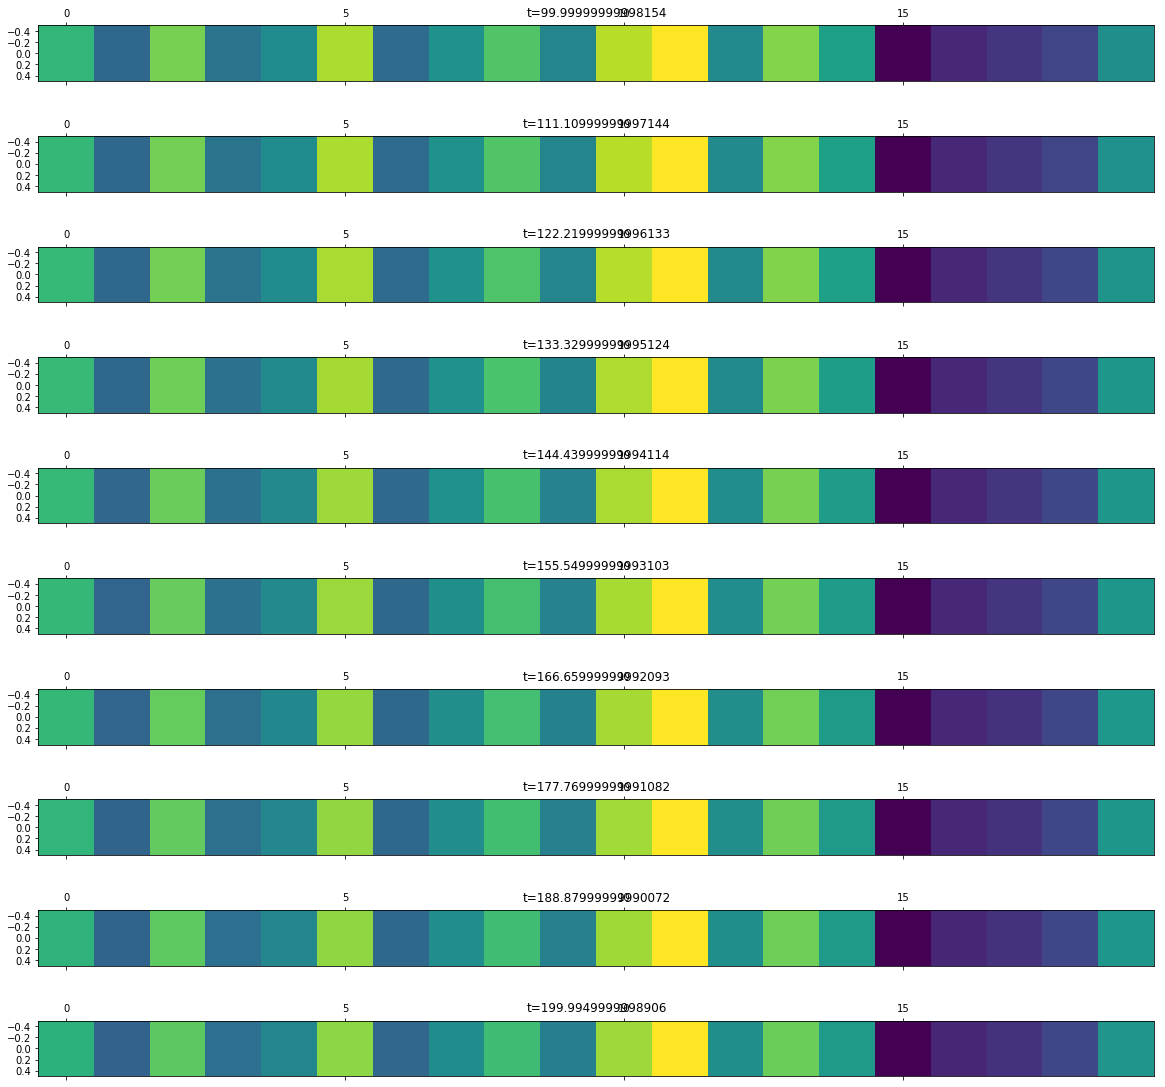

In [16]:
# Visualize S__X weights
n_plots = 10 # number of plots, each at a different time
n_rows = n_plots
n_cols = 1
t_idxs = [int(i) for i in np.linspace(0, len(times)-1, n_plots)]

S__X_fig, S__X_axs = plt.subplots(n_rows, n_cols, figsize=(fs[0], n_rows*fs[1]/3))
for i_plot in range(n_plots):
    row, col = np.divmod(i_plot, n_cols)
    ax = S__X_axs[row]
    cs = ax.matshow(data[x_track][:,t_idxs[i_plot]].reshape(1,N))
    ax.set_title('t='+str(times[t_idxs[i_plot]]))
    
plt.show()

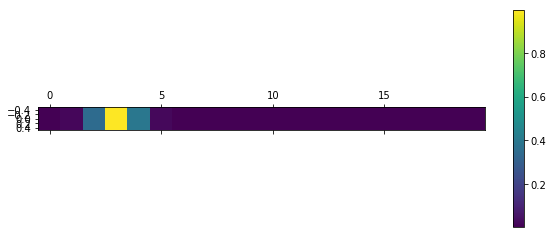

In [37]:
L_out_fig = plt.figure(figsize=(10,4))
axs = plt.subplot(1,1,1)
cs = axs.matshow(net.units[X[0]].s_init.reshape(1,N))
L_out_fig.colorbar(cs)
plt.show()

In [19]:
# repeat calculations
x = net.units[X[0]]
angle = P_data[-1,0]%(2.*np.pi)
d = x.dists(angle)
s_acts = np.exp(-x.s_wid*d*d)
weights = net.units[X[0]].buffer[1:,-1]
I = (s_acts*weights).sum()
print("I = %f"%(I))

d_slow = x.dists(x.lpf_slow_inp_sum % (2.*np.pi))
s_acts_slow = np.exp(-x.s_wid * d_slow * d_slow)
I_slow = (s_acts_slow * weights).sum()
print("I_slow = %f"%(I_slow))

I = -1.281444
I_slow = -0.014060


In [34]:
net.units[X[0]].centers

array([0.        , 0.31415927, 0.62831853, 0.9424778 , 1.25663706,
       1.57079633, 1.88495559, 2.19911486, 2.51327412, 2.82743339,
       3.14159265, 3.45575192, 3.76991118, 4.08407045, 4.39822972,
       4.71238898, 5.02654825, 5.34070751, 5.65486678, 5.96902604])

In [44]:
# reducing the scope of the plots
data_back = data
times_back = times
plant_data_back = [np.array([])]
plant_data_back[0] = plant_data[0]

first_idx=450*200
second_idx=500*200
times = times[first_idx:second_idx]
data = data[:, first_idx:second_idx]
plant_data[0] = plant_data[0][first_idx:second_idx,:]

In [10]:
# recover the data
data = data_back
plant_data[0] = plant_data_back[0]
times = times_back

In [21]:
# Storing the M__C and A__M connections
M__C_mat = np.zeros((2,2)) # rows are target (C) neurons
for m_idx, m_id in enumerate(M):
    for c_idx, c_id in enumerate(C):
        syn_list = net.syns[c_id]
        for syn in syn_list:
            if syn.preID == m_id:
                M__C_mat[c_idx, m_idx] = syn.w
                break
                
A__M_mat = np.zeros((2,4)) # rows are target (M) neurons
for a_idx, a_id in enumerate(A):
    for m_idx, m_id in enumerate(M):
        syn_list = net.syns[m_id]
        for syn in syn_list:
            if syn.preID == a_id:
                A__M_mat[m_idx, a_idx] = syn.w
                break
print(M__C_mat)
print(A__M_mat)

[[1.68646211e-07 2.08082448e+00]
 [2.08121483e+00 1.56862359e-07]]
[[0.34878441 0.25118419 0.16842648 0.13160544]
 [0.12283056 0.08501225 0.43893599 0.25322015]]


In [7]:
plotty = plotter(net, times, data)

In [12]:
plotty.act_anim(S1+S2+L+R+V, 0.5, interv=10, slider=False)

In [8]:
plotty.conn_anim(L, V)

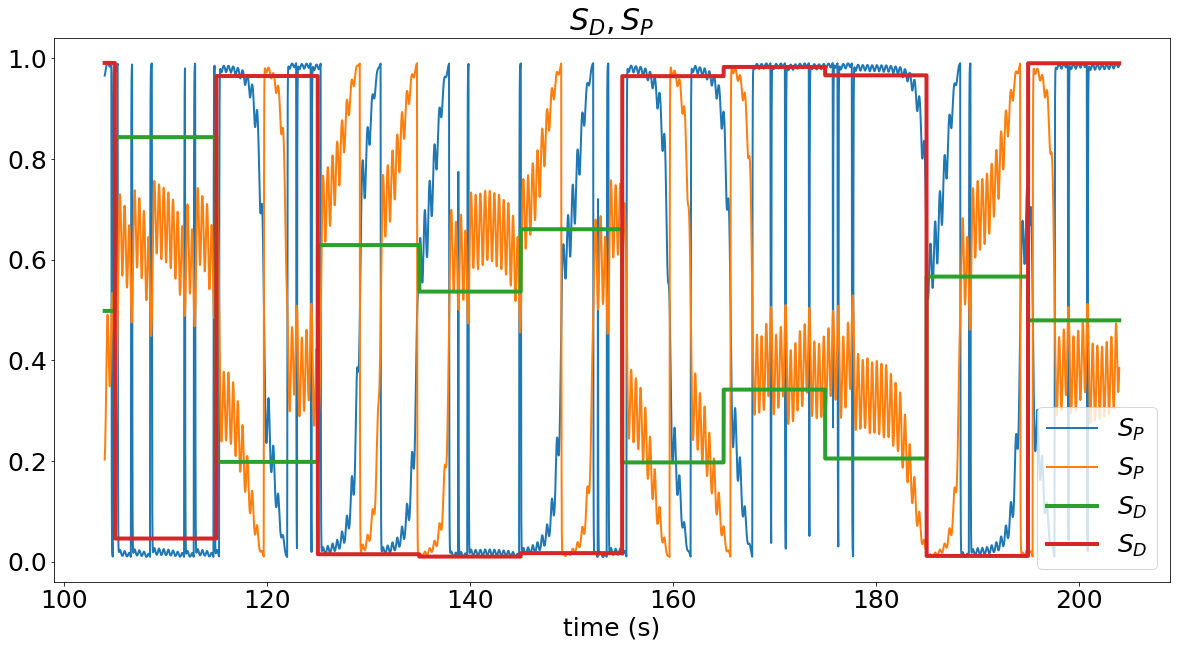

In [18]:
# A figure with more formatting
SPF_fig = plt.figure(figsize=(20,10))
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), label='$S_P$', linewidth=2)
plt.plot(times, SP_data.transpose(), label='$S_D$', linewidth=4)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.xlabel('time (s)', fontsize =25)
plt.title('$S_D, S_P$', fontsize=30)
plt.show()

In [4]:
# good initial weights

# M__C
# M[0] has the F-D error, so you want C[0] (which exerts positive torque)
# to be driven by M[1] instead, and C[1] to be driven by M[0]
shift = 0
while not net.syns[C[0]][shift].type is synapse_types.rga:
    shift += 1
net.syns[C[0]][shift].w = 0.1
net.syns[C[0]][shift+1].w = 0.8 # C[0] driven by M[1]
net.syns[C[1]][shift].w = 0.8
net.syns[C[1]][shift+1].w = 0.1

# L__X, L__V
scale = 1. # maximum weight value
def dist(c1, c2):
    """ Periodic distance between 2-dim coordinates c1 and c2. 

        Assumes c1 and c2 are inside the box with corners [-0.5, -0.5], [0.5, 0.5].
    """
    x_dist = min(max(c1[0], c2[0]) - min(c1[0], c2[0]),  # "inner" distance
                 0.5-max(c1[0], c2[0]) + (min(c1[0], c2[0])+0.5) ) # "outer" distance
    y_dist = min(max(c1[1], c2[1]) - min(c1[1], c2[1]),  # "inner" distance
                 0.5-max(c1[1], c2[1]) + (min(c1[1], c2[1])+0.5) ) # "outer" distance
    return np.sqrt(x_dist*x_dist + y_dist*y_dist)

#L__V_iw = np.zeros((No2, No2))
j = 0
for i in range(len(L)):  # Setting L__V weights
    u = net.units[L[i]]
    c = u.coordinates
    d = dist(c, [c[1], c[1]])
    Vsyn = net.syns[V[0]][i]
    Xsyn = net.syns[X[0]][i+j]
    while Xsyn.type != synapse_types.diff_rm_hebbian:
        j +=1
        Xsyn = net.syns[X[0]][i+j]
    if Vsyn.preID == u.ID and Xsyn.preID == u.ID:
        a, b = divmod(i, No2)
        Vsyn.w = scale*(.5 - d)
        Xsyn.w = 0.01 if abs(c[1]-c[0]) < 0.5-max(c[1],c[0]) + min(c[1],c[0])+0.5 else .8
    else:
        print("FAILED!!!!!!!")